# Direct Regression

In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import r2_score
import pickle
import time

from reed import drop_missing_treatment_or_outcome, Model

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

#### Select modeling parameters

In [4]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-all-lasso.pkl"#"data/cross-val-all.pkl"
bootstrap_cache = "data/bootstrap-all-lasso.pkl"#"data/bootstrap-all.pkl"
data_file = "all_lasso_selected.csv"#"all_vars.csv"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [5]:
data = pd.read_csv(data_file,index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [34]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':np.linspace(0,1,6)[1:],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

# def construct_models(): Used for quick testing
#     models = [
#         Model('Ridge',Ridge(),
#               parameters = {'alpha':np.logspace(1,4,2)},
#               importance_func=importance_from_coef
#         ),
#         Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
#               parameters = {
#                 'max_features':[10],
#                 'learning_rate':np.logspace(-3,0,2),
#               }
#         ), 
#     ]
#     return models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [35]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)

print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)


Control data dimensions:  (3659, 107)
Treated data dimensions: (1295, 107)


### Compute unconditional/unadjusted estimate of treatment effect

In [36]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:67.85±15.36
Average outcome under Treatment:310.57±29.39
Unadjusted treatment estimate 242.72


### Propensity model

- Run primarily to check for violations over overlap assumptions.

In [37]:
from reed import visualise_propensity_model_performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train, X_test, t_train, t_test = train_test_split(X,t,stratify=t)
pmodel = LogisticRegressionCV(Cs = np.logspace(-5,-1,20), penalty='l2', max_iter=10000)
pmodel.fit(X_train, t_train);

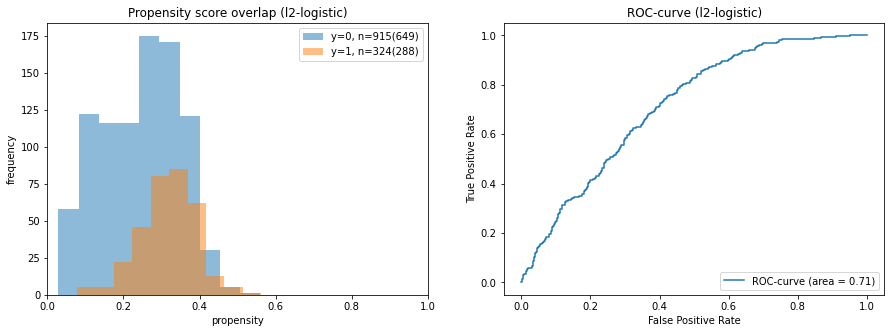

In [38]:
visualise_propensity_model_performance(t_test, pmodel.predict_proba(X_test)[:,1],'l2-logistic',bins=10)

In [39]:
def propensity_coefficients(model, features):
    if hasattr(model,'best_estimator_'):
        model = model.best_estimator_
    coef = model.coef_[0]
    
    with open('data/metadata.pkl','rb') as f:
        meta = pickle.load(f)
        labels = [meta.column_names_to_labels.get(f) for f in features]
    return pd.DataFrame({'label': labels, "c":coef,'abs':np.abs(coef)},index=features).sort_values(by='abs',ascending=False).head(50)
print("Propensity Model Coefficients")      
propensity_coefficients(pmodel, features).head(20)

Propensity Model Coefficients


,label,c,abs
ahgage,DV: Age last birthday at June 30 2001,-0.119490,0.119490
aicage1,H25 Check age,-0.101302,0.101302
ahhold,DV: Age of oldest person in household,-0.088556,0.088556
amrpyr,J2a Year - present or most recent marriage,0.078670,0.078670
ahgsex,HF3 Sex,0.059475,0.059475
abncpen,DV: Current weekly Australian Government Pensions ($),-0.052237,0.052237
ajbmssec,E36b Job security satisfaction,-0.047382,0.047382
aujyru,D12 How long since last worked for pay - years (not currently in paid work),-0.046337,0.046337
abnftbf1,DV: Family number 1 Family Tax Benefit B ($) financial year [estimated],0.043291,0.043291
acaj0145,FG1 Calendar - Job 1 - Late Sep 2001,-0.038110,0.038110


### (Nested) cross-validate to evaluate model performance
![image.png](images/nested_cross_val.png)

In [40]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=5,
    outercv=50,
    load_from_cache=False
)

Fitting ridge ...Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.336e+05, tolerance: 1.191e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e+05, tolerance: 1.191e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.419e+06, tolerance: 1.133e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.371e+05, tolerance: 1.133e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e+07, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.568e+06, tolerance: 1.118e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.270e+06, tolerance: 1.096e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.032e+05, tolerance: 1.096e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.573e+05, tolerance: 1.186e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.513e+05, tolerance: 1.186e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e+05, tolerance: 1.208e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e+05, tolerance: 1.058e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.396e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.483e+07, tolerance: 1.212e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.947e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+07, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.893e+06, tolerance: 1.101e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e+05, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.199e+05, tolerance: 1.178e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.121e+05, tolerance: 1.150e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e+06, tolerance: 1.150e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e+07, tolerance: 1.168e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.049e+06, tolerance: 1.168e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+06, tolerance: 1.087e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+07, tolerance: 1.087e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.087e+06, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.086e+05, tolerance: 1.108e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.496e+05, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.061e+05, tolerance: 1.169e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.844e+06, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.218e+05, tolerance: 1.130e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.245e+07, tolerance: 1.184e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e+07, tolerance: 1.184e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e+06, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.114e+05, tolerance: 1.124e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.771e+05, tolerance: 1.196e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e+06, tolerance: 1.196e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.672e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.001e+06, tolerance: 1.144e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e+07, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.774e+07, tolerance: 1.129e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.124e+05, tolerance: 1.090e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+05, tolerance: 1.090e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e+07, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.672e+06, tolerance: 1.142e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e+07, tolerance: 1.184e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.078e+06, tolerance: 1.184e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.142e+05, tolerance: 1.089e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e+06, tolerance: 1.205e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.861e+06, tolerance: 1.205e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.746e+05, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.148e+05, tolerance: 1.181e+05
  model = cd_fast.enet_coordinate_descent(


Done
Fitting gbr ...Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for 

### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,0.65,9.19,0.19,0.15,0.14,0.20,"-707,445.45","569,456.91","-909,290.69","738,371.16"
lasso,-6.30,7.62,0.21,0.14,0.21,0.16,"-699,045.26","529,274.32","-855,178.45","734,534.04"
gbr,45.25,12.91,0.30,0.15,0.18,0.16,"-626,538.58","488,197.55","-899,111.91","876,204.65"


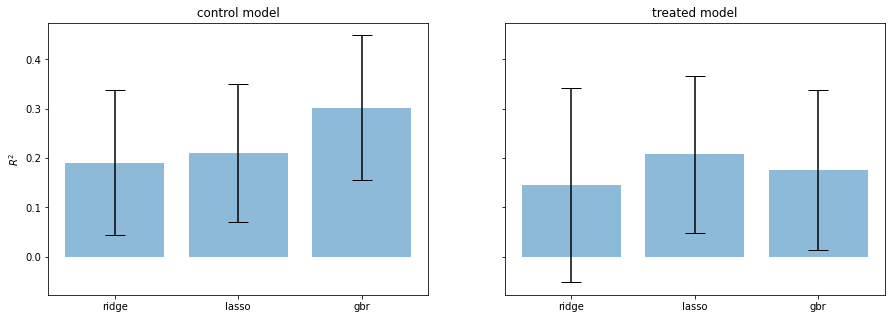

In [41]:
from direct_regression import visualise_ate
metrics, ate_vals = visualise_ate(results,X,evaluation_metrics);

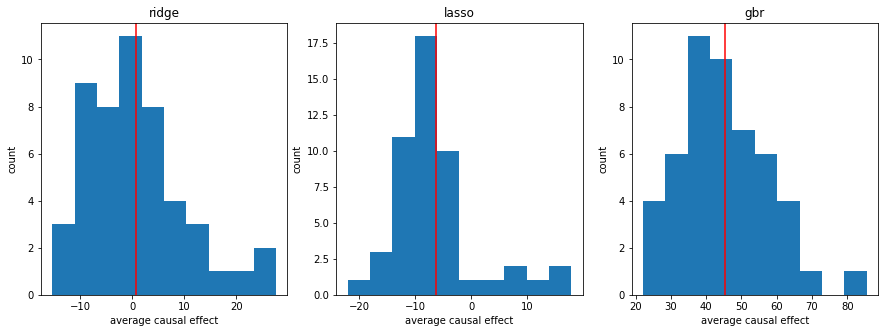

In [42]:
from direct_regression import plot_ate_distribution
plot_ate_distribution(ate_vals)

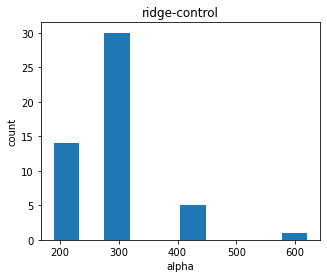

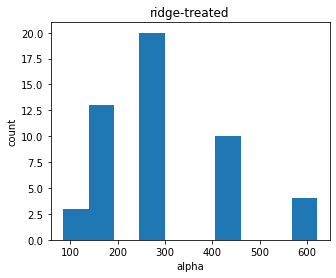

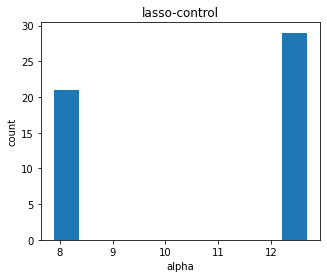

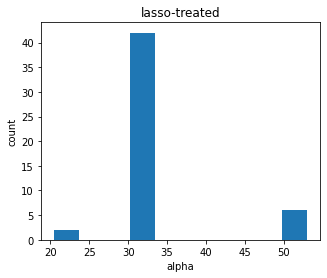

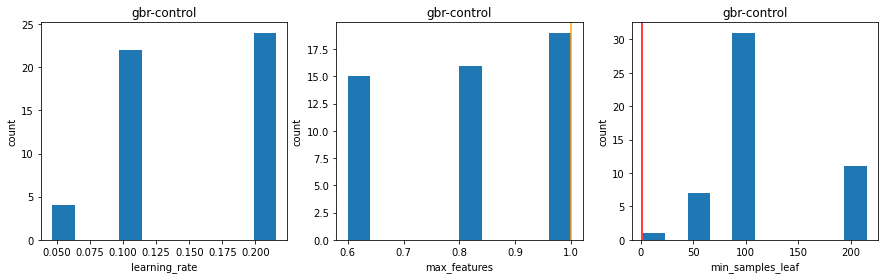

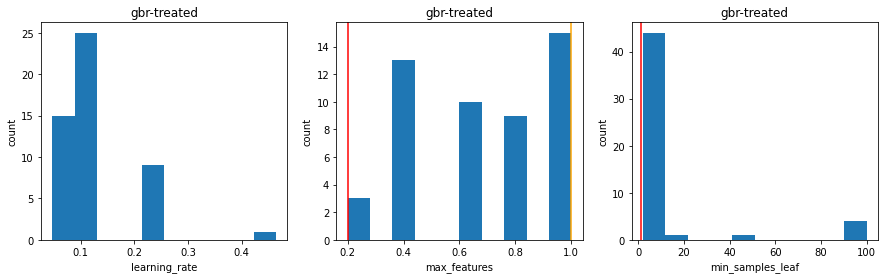

In [43]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models
      - TODO permutation importance & partial dependence curves for non-linear models

In [44]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

ridge


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
awsce,256.283168,22.015237,-17.660324,43.706443,-265.113330,39.365914,-247.453006,19.359565
ahgage,235.488948,20.040497,57.241246,40.117535,-206.868324,34.803156,-264.109571,19.917121
ahhold,103.352500,3.721226,37.325430,9.088323,-84.689785,7.389906,-122.015215,3.792512
arcage1,69.747201,2.659689,-37.014000,5.373134,-88.254201,4.533845,-51.240201,2.833271
ahiwsfei,57.962791,11.677705,112.467390,23.923827,111.390902,23.095763,-1.076489,6.979520
amrpyr,56.520668,3.385985,61.835985,7.940626,87.438660,5.942132,25.602675,4.375800
ahgsex,50.208929,7.347077,-15.059989,13.631424,-57.738924,13.400839,-42.678935,4.613508
atxdic,48.887962,10.524833,-96.737731,20.764426,-96.530789,20.620320,0.206942,2.042512
atifprip,46.610776,5.197670,-93.221552,10.395340,-51.811877,5.952013,41.409675,7.828453


lasso


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
ahgage,356.402330,11.402368,3.713894,15.723191,-354.545383,14.316368,-358.259277,13.367085
awsce,297.143059,15.699644,-59.601933,21.281867,-326.944025,17.453377,-267.342092,20.366546
arcage1,57.685175,2.933895,-20.861915,4.503302,-68.116133,3.563221,-47.254218,3.828680
ahiwsfei,48.952631,7.199320,97.905262,14.398639,97.810087,14.340600,-0.095176,0.672993
ahhold,45.790562,4.519548,25.655060,8.511156,-32.963032,7.894055,-58.618092,3.841408
aicage1,38.472710,4.128613,-76.945420,8.257225,0.000000,0.000000,76.945420,8.257225
ahgsex,36.752442,6.295980,24.941430,11.218689,-24.281727,11.091563,-49.223156,4.380120
atxdic,32.500182,7.909336,-65.000364,15.818672,-65.000364,15.818672,0.000000,0.000000
aioundst,30.672119,3.148371,-10.054607,5.087493,-35.699422,5.268119,-25.644815,2.238905


### Compare against OLS on basic variables

In [45]:
basic = pd.read_csv("basic_variables.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(basic, treatment, outcome)
if log_outcome:
    basic[outcome] = np.log(basic[outcome]+basic[outcome].min())
    
X0b, X1b, y0b, y1b, Xb, yb, tb, featuresb = seperate_and_transform_data(basic, treatment, outcome)

def construct_basic_model():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

modelsb0, modelsb1, resultsb = nested_cross_val(
    construct_basic_model,
    "data/tmp.pkl",
    X0b, X1b, y0b, y1b,
    optimisation_metric,
    evaluation_metrics,
    innercv=5,
    outercv=10,
    load_from_cache=True)

Dropped 592 rows missing treatment or outcome.


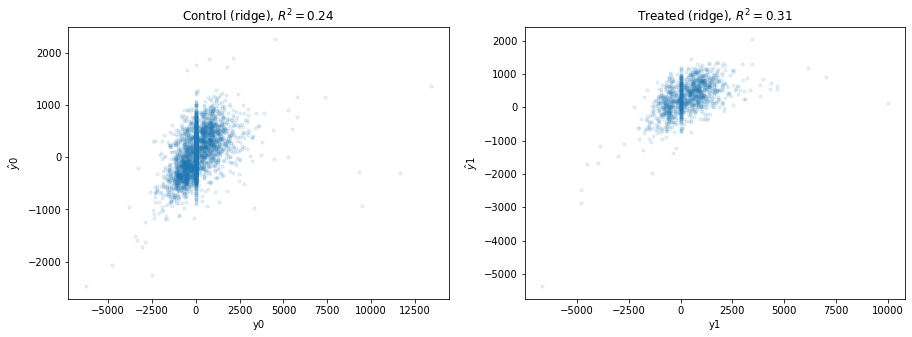

In [46]:
y0a = results['ridge'][0]['estimator'][4].predict(X0)
y1a = results['ridge'][1]['estimator'][4].predict(X1)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0a,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (ridge), $R^2={r2_score(y0,y0a):.2f}$')

ax[1].scatter(y1, y1a,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (ridge), $R^2={r2_score(y1,y1a):.2f}$');

# think about why these r2 scores are higher than on the holdout set (and whether they are likely overfitting)

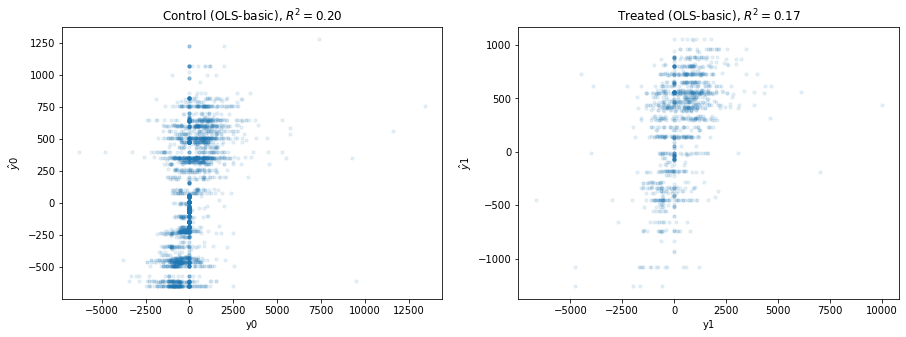

In [47]:
from sklearn.metrics import r2_score
y0b = resultsb['OLS'][0]['estimator'][0].predict(X0b)
y1b = resultsb['OLS'][1]['estimator'][0].predict(X1b)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0b,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (OLS-basic), $R^2={r2_score(y0,y0b):.2f}$')

ax[1].scatter(y1, y1b,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (OLS-basic), $R^2={r2_score(y1,y1b):.2f}$');


### Bootstraped cross-validation to estimate parameter uncertainty
![image.png](images/bootstrap_validation.png)

In [48]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_

bootstrap_results = bootstrapped_cross_val(
    construct_models,
    bootstrap_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=5,
    load_from_cache=False,
    samples=20
)

Fitting ridge ...Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.014e+07, tolerance: 1.325e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.576e+07, tolerance: 1.325e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.491e+08, tolerance: 1.318e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.008e+05, tolerance: 1.183e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.866e+05, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e+06, tolerance: 1.192e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e+08, tolerance: 1.203e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+08, tolerance: 1.203e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e+07, tolerance: 1.045e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.151e+07, tolerance: 1.045e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e+06, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.384e+05, tolerance: 1.125e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e+08, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e+08, tolerance: 1.049e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.844e+06, tolerance: 1.039e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.041e+06, tolerance: 1.132e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.669e+07, tolerance: 9.290e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.323e+07, tolerance: 9.290e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+05, tolerance: 1.071e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.186e+05, tolerance: 1.071e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.371e+08, tolerance: 1.086e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e+08, tolerance: 1.086e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.134e+06, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e+07, tolerance: 1.127e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.831e+08, tolerance: 1.149e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+07, tolerance: 1.424e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.001e+07, tolerance: 9.564e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.642e+07, tolerance: 9.564e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+07, tolerance: 1.165e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.938e+07, tolerance: 1.165e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e+07, tolerance: 1.210e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.766e+07, tolerance: 1.210e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.380e+08, tolerance: 1.022e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e+07, tolerance: 1.005e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e+06, tolerance: 1.022e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.422e+06, tolerance: 1.348e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+07, tolerance: 1.348e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.971e+05, tolerance: 1.327e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e+06, tolerance: 1.353e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e+06, tolerance: 1.038e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.051e+05, tolerance: 1.038e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+08, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.977e+07, tolerance: 1.200e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Done
Fitting gbr ...Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for 

####  Average treatment effects

In [49]:
from direct_regression import compute_ate
metrics, tau_estimatesb = compute_ate(bootstrap_results,X)
metrics

,ACE,ACE_std
ridge,24.229587,24.960366
lasso,29.207305,35.707897
gbr,64.292523,30.354593


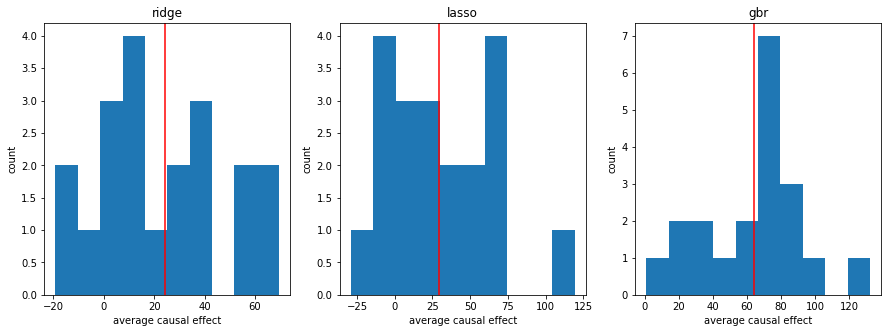

In [50]:
plot_ate_distribution(tau_estimatesb)

#### Distribution of hyper-parameters

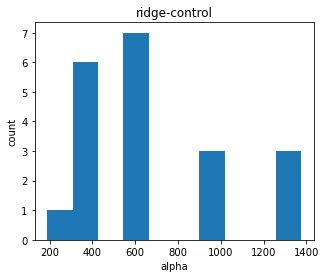

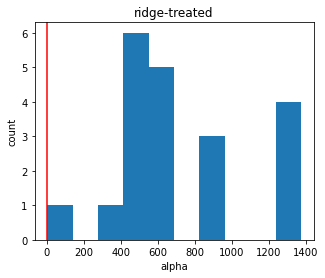

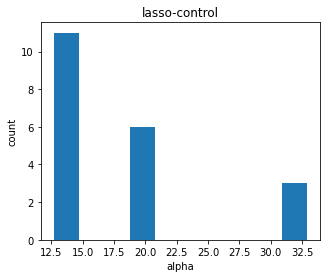

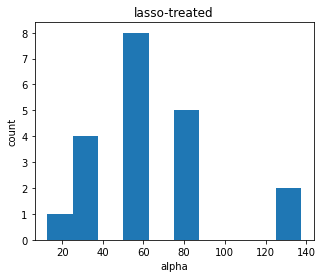

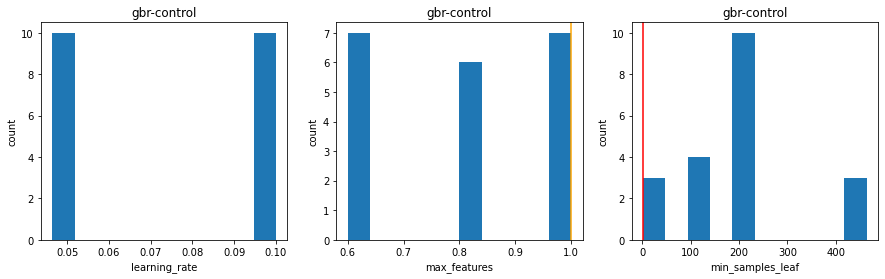

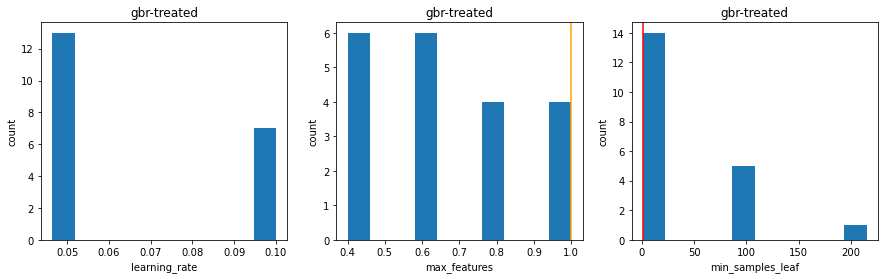

In [51]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")